In [1]:
import sys
sys.path.insert(1, '../scripts')

In [3]:
# data processing
import random
from scipy import stats
import pandas as pd
from Bio import AlignIO
import alignment_quality as aq
import crutil as util

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
all_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [6]:
def get_region_msa_from_df(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    return region_msa

In [7]:
def append_alignment_quality(row):
    region_msa = get_region_msa_from_df(row)
    gappiness = aq.compute_alignment_quality(region_msa)
    seq_div = aq.get_seq_divergence_from_region_msa(region_msa, all_aa)
    return pd.Series(dict(gappiness=gappiness, seq_div=seq_div))

In [8]:
def get_uncharged_region_ranges(charged_regions, msa_len):
    uncharged_regions = []
    
    if charged_regions[0][0] != 0:
        uncharged_regions.append((0, charged_regions[0][0] - 1))
        
    start = charged_regions[0][1] + 1
    for region in charged_regions[1:]:
        uncharged_regions.append((start, region[0]-1))
        start = region[1] + 1

    if charged_regions[-1][1] != (msa_len - 1):
        uncharged_regions.append((charged_regions[-1][1], msa_len-1))
        
    return uncharged_regions

In [9]:
def extract_uncharged_region_msa(msa, charged_regions):
    uncharged_regions = get_uncharged_region_ranges(charged_regions, len(msa[0]))
    for record in msa:
        uncharged_seq = ''
        for region in uncharged_regions:
            uncharged_seq += record.seq[region[0]:(region[1]+1)]
        record.seq = uncharged_seq
    return msa

In [10]:
def append_null_alignment_quality(row):
    orf = row['orf']
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    charged_regions = ranges_dict[orf]
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    regionlen = msa_right_bound - msa_left_bound
    uncharged_region_msa = extract_uncharged_region_msa(msa, charged_regions)
    random_region_msa = aq.extract_random_region_from_msa(uncharged_region_msa, regionlen)
    
    gappiness = aq.compute_alignment_quality(random_region_msa)
    seq_div = aq.get_seq_divergence_from_region_msa(random_region_msa, all_aa)
        
    return pd.Series(dict(gappiness_null=gappiness, seq_div_null=seq_div))

In [11]:
def extract_random_region_from_proteome(fdir, regionlen, valid_orfs):
    msa = None
    cnt = 0
    while msa is None:
        orf_i = random.randrange(len(valid_orfs))
        orf = valid_orfs[orf_i]
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        if len(msa[0].seq) <= regionlen:
            msa = None
        cnt += 1
        if cnt >= 20:
            print(regionlen)
    starti = random.randrange(len(msa[0].seq) - regionlen)
    random_msa = msa[:, starti:(starti + regionlen)]    
    return random_msa

## Compute alignment quality for all hits - threshold 0.4

In [12]:
df = pd.read_csv('../../data/charged_regions/cr_filtered.csv', comment='#')

In [13]:
aybrah_path = '/mnt/d/research/drummond-lab/data/aybrah-all/'

In [14]:
msa = AlignIO.read(open(aybrah_path+str('YCL011C')+'-aybrah.fa'), "fasta")

In [15]:
df = df.join(df.apply(append_alignment_quality, axis="columns"))

In [16]:
df[df['gappiness'].isna()]

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,gappiness,seq_div
62,YBR278W,DPB3,202,108,166,QPGRSDQEVVIEEPELHEDDGVEEEEEEDEVSEEEEPVHNEELLDD...,59,0.273446,0.508475,0.114140,0.416735,P27344,verified,NaN,NaN
433,YIL149C,MLP2,1680,60,106,KLKQLLDESSEQKNTAKEELNGLKDQLNEERSRYRREIDALKKQLHV,47,0.001013,0.446809,0.073132,0.185590,P40457,verified,NaN,NaN


In [17]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
ranges_dict = {}
for index, row in df.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if orf not in ranges_dict:
        ranges_dict[orf] = []
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    ranges_dict[orf].append((msa_left_bound, msa_right_bound))

In [18]:
df = df.join(df.apply(append_null_alignment_quality, axis="columns"))

In [19]:
verified_orfs_with_msa = pd.read_csv('../..//data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

In [20]:
df = df.dropna(how='any')

In [21]:
#df.to_csv('./data/charged-regions-aq.csv', index=False)

In [21]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
df_random = pd.DataFrame(columns = ['gappiness', 'seq_div'])
for k,v in ranges_dict.items():
    for charged_region in v:
        regionlen = charged_region[1] - charged_region[0] + 1
        random_msa = extract_random_region_from_proteome(fdir, regionlen, valid_orfs)
        gappiness = aq.compute_alignment_quality(random_msa)
        seq_div = aq.get_seq_divergence_from_region_msa(random_msa, all_aa)
        df_random = df_random.append({'gappiness': gappiness, 'seq_div': seq_div}, ignore_index=True)

In [22]:
df_random = df_random.dropna(how='any')

## Alignment quality of IDRs

In [23]:
df_disprot = pd.read_table('../../data/misc/search_in_disprot.tsv')

In [24]:
with open('../../data/misc/uniprot-to-sgdid.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[uniprot] = orf

In [25]:
verified_orfs_with_msa = pd.read_csv('../../data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

In [26]:
def append_orf_name(row):
    orf = mappings[row['acc']]
    return orf

In [27]:
df_disprot['orf'] = df_disprot.apply(lambda row:append_orf_name(row), axis=1)

In [28]:
df_disprot = df_disprot[df_disprot['orf'].isin(valid_orfs)]

In [29]:
def append_alignment_quality_disprot(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']
    refseq = row['region_sequence']
    left_bound = row['start']
    right_bound = row['end']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    gappiness = aq.compute_alignment_quality(region_msa)
    seq_div = aq.get_seq_divergence_from_region_msa(region_msa, all_aa)
    return pd.Series(dict(gappiness=gappiness, seq_div=seq_div))

In [30]:
df_disprot = df_disprot.join(df_disprot.apply(append_alignment_quality_disprot, axis="columns"))

In [31]:
df_disprot = df_disprot[df_disprot['gappiness'].notna()]

## Summary plot for gappiness

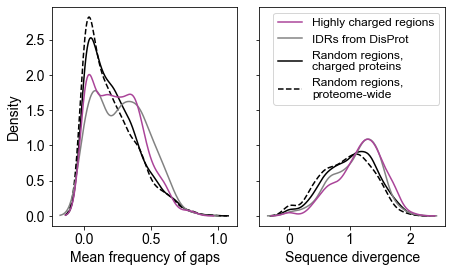

In [37]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6.5,4))
ax1, ax2 = axes[0], axes[1]

sns.kdeplot(data=df, x='gappiness', color='#AA4499', ax=ax1, zorder=4)
sns.kdeplot(data=df_disprot, x='gappiness', color='#828282', ax=ax1, zorder=3)
sns.kdeplot(data=df, x='gappiness_null', color='black', ax=ax1, zorder=2)
sns.kdeplot(data=df_random, x='gappiness', color='black', ax=ax1, linestyle='--', zorder=1)
ax1.set_xlabel('Mean frequency of gaps')
ax1.set_ylabel('Density')

sns.kdeplot(data=df, x='seq_div', color='#AA4499', ax=ax2, zorder=4)
sns.kdeplot(data=df_disprot, x='seq_div', color='#828282', ax=ax2, zorder=3)
sns.kdeplot(data=df, x='seq_div_null', color='black', ax=ax2, zorder=2)
sns.kdeplot(data=df_random, x='seq_div', color='black', ax=ax2, linestyle='--', zorder=1)
ax2.set_xlabel('Sequence divergence')

ax2.legend(['Highly charged regions',
            'IDRs from DisProt',
            'Random regions,\ncharged proteins',
            'Random regions,\nproteome-wide'],
           fontsize=12)
plt.tight_layout()
plt.savefig('../../figures/plots/Figure3.4A.png', dpi=300)
plt.show()

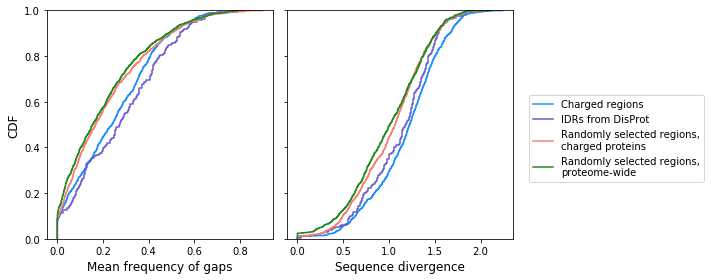

In [33]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))
ax1, ax2 = axes[0], axes[1]

sns.ecdfplot(data=df, x='gappiness', color='dodgerblue', ax=ax1)
sns.ecdfplot(data=df_disprot, x='gappiness', color='slateblue', ax=ax1)
sns.ecdfplot(data=df, x='gappiness_null', color='salmon', ax=ax1)
sns.ecdfplot(data=df_random, x='gappiness', color='forestgreen', ax=ax1)
ax1.set_xlabel('Mean frequency of gaps', fontsize=12)
ax1.set_ylabel('CDF', fontsize=12)

sns.ecdfplot(data=df, x='seq_div', color='dodgerblue', ax=ax2)
sns.ecdfplot(data=df_disprot, x='seq_div', color='slateblue', ax=ax2)
sns.ecdfplot(data=df, x='seq_div_null', color='salmon', ax=ax2)
sns.ecdfplot(data=df_random, x='seq_div', color='forestgreen', ax=ax2)
ax2.set_xlabel('Sequence divergence', fontsize=12)

plt.legend(['Charged regions',
            'IDRs from DisProt',
            'Randomly selected regions,\ncharged proteins',
            'Randomly selected regions,\nproteome-wide'],
           bbox_to_anchor=(1.05, 0.65))
plt.tight_layout()
#plt.savefig('./figures/alignment-quality-medthreshold.png', dpi=500)
plt.show()

### Statistical tests

In [34]:
stats.ks_2samp(df['gappiness'], df['gappiness_null'])

Ks_2sampResult(statistic=0.13005464480874318, pvalue=3.66687471800144e-07)

In [35]:
stats.ks_2samp(df['gappiness'], df_random['gappiness'])

Ks_2sampResult(statistic=0.15247121389539423, pvalue=1.1669003541214806e-09)

In [36]:
stats.ks_2samp(df['gappiness'], df_disprot['gappiness'])

Ks_2sampResult(statistic=0.09764033780427223, pvalue=0.014375492767865539)

In [37]:
stats.ks_2samp(df['gappiness_null'], df_random['gappiness'])

Ks_2sampResult(statistic=0.05030127829820453, pvalue=0.1928497155802853)

In [38]:
stats.ks_2samp(df['seq_div'], df['seq_div_null'])

Ks_2sampResult(statistic=0.18032786885245902, pvalue=2.0663533724242306e-13)

In [39]:
stats.ks_2samp(df['seq_div'], df_random['seq_div'])

Ks_2sampResult(statistic=0.20357020882123342, pvalue=2.3314683517128287e-15)

In [40]:
stats.ks_2samp(df['seq_div'], df_disprot['seq_div'])

Ks_2sampResult(statistic=0.09356681569796324, pvalue=0.021604769618255637)

## Clustering

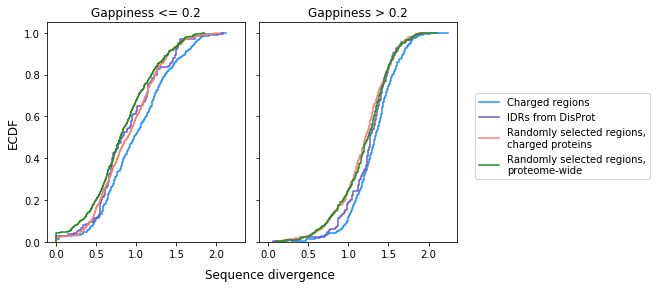

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
ax1, ax2 = axes[0], axes[1]

for ax in [ax1, ax2]:
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(' ')
    
sns.ecdfplot(data=df[df.gappiness <= 0.2], x='seq_div', color='dodgerblue', ax=ax1)
sns.ecdfplot(data=df_disprot[df_disprot.gappiness <= 0.2], x='seq_div', color='slateblue', ax=ax1)
sns.ecdfplot(data=df[df.gappiness_null <= 0.2], x='seq_div_null', color='salmon', ax=ax1)
sns.ecdfplot(data=df_random[df_random.gappiness <= 0.2], x='seq_div', color='forestgreen', ax=ax1)
ax1.set_ylabel('ECDF', fontsize=12)
ax1.set_title('Gappiness <= 0.2', fontsize=12)

sns.ecdfplot(data=df[df.gappiness > 0.2], x='seq_div', color='dodgerblue', ax=ax2)
sns.ecdfplot(data=df_disprot[df_disprot.gappiness > 0.2], x='seq_div', color='slateblue', ax=ax2)
sns.ecdfplot(data=df[df.gappiness_null > 0.2], x='seq_div_null', color='salmon', ax=ax2)
sns.ecdfplot(data=df_random[df_random.gappiness > 0.2], x='seq_div', color='forestgreen', ax=ax2)
ax2.set_title('Gappiness > 0.2', fontsize=12)

ax2.legend(['Charged regions',
            'IDRs from DisProt',
            'Randomly selected regions,\ncharged proteins',
            'Randomly selected regions,\nproteome-wide'],
           bbox_to_anchor=(2, 0.7))
fig.text(0.38, 0.02, 'Sequence divergence', ha='center', fontsize=12)
plt.tight_layout()
#plt.savefig('./figures/alignment-quality-medthreshold.png', dpi=500)
plt.show()